# Predicting Composer of a Musical Piece
## AAI-511 Team 7 Final Project

Team 7:  Tyler Foreman

University of San Diego, Applied Artificial Intelligence

Date:  August 12, 2024

GitHub Repository: https://github.com/t4ai/aai-511-final-project

In [ ]:
!pip install pretty_midi

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import os
import shutil
import pretty_midi

## Data Organization and Exploratory Analysis

1.  Extract music files for only the composers of interest - remove all others
2.  Conduct EDA on the target data:
  - Undersand the nature of the files and formats
  - Evaluate the distribution of samples by composer/class
  - Evaluate the length of the music tracks (in time)
  - Identify any preparation or augmentation tasks that may be necessary

In [9]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# setup target data locations
root_data_path = '/content/drive/MyDrive/USD/datasets/composers_music'
target_data_path = '/content/drive/MyDrive/USD/datasets/composers_music/target'

In [11]:
# setup data prep parameters
SAMPLE_FREQUENCY = 20
MAX_SEQUENCE_LENGTH = 1000

# helper function for moving and flattening directories by composer
def move_and_flatten(composer_name):
  # setup destination
  target_path = target_data_path + '/' + composer_name
  os.makedirs(target_path, exist_ok=True)

  # get source dir and subdirs
  composer_path = root_data_path + '/midiclassics/' + composer_name
  composer_dirs = [x[0] for x in os.walk(composer_path)]

  # traverse directories
  num_files = 0
  for dir in composer_dirs:
    for filename in os.listdir(dir):
      if os.path.isfile(os.path.join(dir, filename)):
        shutil.copyfile(dir + '/' + filename, target_path + '/' + filename)
        num_files += 1
  print(f'Moved {num_files} files for {composer_name}')

# helper function for loading piano rolls for a composer
def load_piano_rolls(composer_name, frequency):
  piano_rolls = []
  target_path = target_data_path + '/' + composer_name
  for filename in os.listdir(target_path):
    if filename.lower().endswith('.mid'):
      try:
        midi = pretty_midi.PrettyMIDI(target_path + '/' + filename)
        midi.remove_invalid_notes()
        piano_rolls.append(midi.get_piano_roll(fs=frequency))
      except Exception as e:
        print(f'Error reading {filename}: {e}')
  return piano_rolls

In [107]:
# extract only the files from our taget 4 composers: Bach, Beethoven, Mozart, Chopin
os.makedirs(target_data_path, exist_ok=True)

move_and_flatten('Bach')
move_and_flatten('Beethoven')
move_and_flatten('Mozart')
move_and_flatten('Chopin')

Moved 1025 files for Bach
Moved 219 files for Beethoven
Moved 257 files for Mozart
Moved 136 files for Chopin


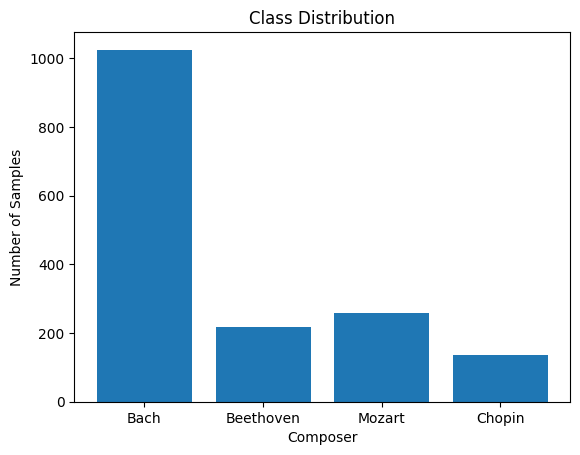

In [25]:
# visualize class balances
class_samples = {"Bach": 1025, "Beethoven": 219, "Mozart": 257, "Chopin": 136}
plt.bar(class_samples.keys(), class_samples.values())
plt.xlabel('Composer')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

In [12]:
# get the distribution of sequence lengths of the pieces (in time)
bach_data = load_piano_rolls('Bach', SAMPLE_FREQUENCY)
beethoven_data = load_piano_rolls('Beethoven', SAMPLE_FREQUENCY)
mozart_data = load_piano_rolls('Mozart', SAMPLE_FREQUENCY)
chopin_data = load_piano_rolls('Chopin', SAMPLE_FREQUENCY)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error reading Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error reading K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


In [14]:
# build length distribution
length_distributions = []
def append_lengths(data):
  for i in range(len(data)):
    length_distributions.append(data[i].shape[1])

In [15]:
append_lengths(bach_data)
append_lengths(beethoven_data)
append_lengths(mozart_data)
append_lengths(chopin_data)

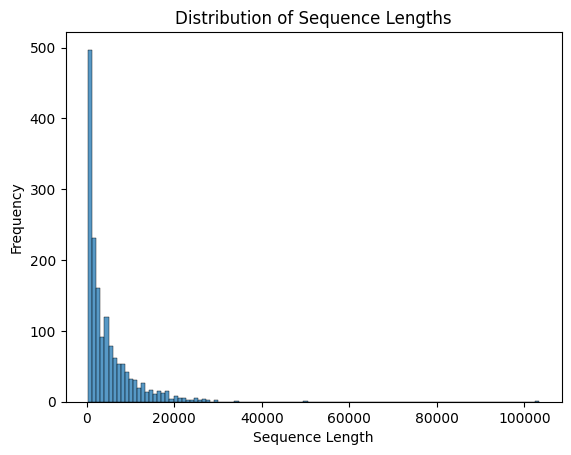

In [16]:
sns.histplot(length_distributions)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()